In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import cv2
import time
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
import rospy
from scipy.spatial.transform import Rotation as R
import torchvision.models as models
import itertools

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class ModResNet2(nn.Module):
    def __init__(self, in_chans, out):
        super(ModResNet2, self).__init__()
        original_model = models.resnet101(pretrained=True)
        original_model.conv1 = nn.Conv2d(
                    in_channels=in_chans, 
                    out_channels=original_model.conv1.out_channels,
                    kernel_size=original_model.conv1.kernel_size,
                    stride=original_model.conv1.stride,
                    padding=original_model.conv1.padding,
                    bias=original_model.conv1.bias)
        
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            original_model.relu,
            original_model.maxpool,
            original_model.layer1,
            original_model.layer2,
            original_model.layer3,
            original_model.layer4
        )
        self.avgpool = original_model.avgpool
        
        num_features = original_model.fc.in_features
        num_out_feas = out
        original_model.fc = nn.Linear(num_features, num_out_feas)
        self.fc = original_model.fc  
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out_fc = self.fc(x)
        return out_fc

In [4]:
class PoseTransformer(nn.Module):
    def __init__(self, num_layers=3, embed_dim=256, num_heads=8, ff_dim=512, 
                 dropout=0.1, out_dim=24):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, 361, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(embed_dim, out_dim)
        self.embed_dim = embed_dim

    def forward(self, x):
        B = x.shape[0]
        x = x.view(B, self.embed_dim, -1).permute(0, 2, 1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        return x

In [5]:
class align_net(nn.Module):
    def __init__(self):
        super(align_net, self).__init__()
        self.model = ModResNet2(3,512)
        self.lin4d = PoseTransformer(embed_dim=512, num_layers=2, out_dim=3)
        self.lin4c = PoseTransformer(embed_dim=512, num_layers=2, out_dim=3)
    def forward(self, rgb):
        feask = self.model(rgb)
        p_t = self.lin4d(feask)
        p_r = self.lin4c(feask)
        return p_t, p_r

In [6]:
class feedback_net(nn.Module):
    def __init__(self):
        super(feedback_net, self).__init__()
        self.model = ModResNet2(3,512)
        self.lin4c = PoseTransformer(embed_dim=512, out_dim=1, num_layers=4) 
    def forward(self, rgb):
        feas_c = self.model(rgb.float().to(device))
        pred_score = self.lin4c(feas_c)
        return pred_score

In [ ]:
lsfunc = nn.SmoothL1Loss().to(device)
mod1 = align_net() ##Alignment network
mod1.load_state_dict(torch.load('./INAF/releases/mod_smb_real9i.pth')) #Load pretrained weight
mod1 = mod1.to(device).train()
optimz = optim.Adam([{'params': mod1.parameters(), 'lr': 1e-4}])

/home/thomas/anaconda3/envs/yolov8/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thomas/anaconda3/envs/yolov8/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
pos_dir = './0data/0_dir/'
score_dir = './0data/1_dir/'
img_dir = './0data/2_dir/'

In [9]:
def training_loop1(d_set, optimz, lossfn, mod1):
    img_tsr, gt_trans, gt_rot = d_set
    pred_pose = mod1(img_tsr.to(device))
    p_t, p_r = pred_pose
    loss_1 = 100*lossfn(p_r, gt_rot.to(device))
    loss_2 = 1000*lossfn(p_t, gt_trans.to(device))
    print("loss_1: ", loss_1)
    print("loss_2: ", loss_2)
    losst = loss_1 + loss_2 
    if torch.is_tensor(losst):   
        optimz.zero_grad() 
        losst.backward()
        optimz.step()
 
    with torch.no_grad():
        a_loses = [loss_1, loss_2, losst]
        for i, i_loss in enumerate(a_loses):
            if torch.is_tensor(i_loss):
                a_loses[i] = i_loss.item()
            else:
                a_loses[i] = None
        return a_loses

In [10]:
def training_loop2(d_set, optimz, lossfn, mod2):
    img_tsr, gt_score = d_set
    pred_score = torch.sigmoid(mod2(img_tsr.to(device)))
    loss_3 = 1000*lossfn(pred_score, gt_score.to(device))
    print("loss_3: ", loss_3)
    losst = loss_3 
    if torch.is_tensor(losst):   
        optimz.zero_grad() 
        losst.backward()
        optimz.step()
    with torch.no_grad():
        a_loses = [losst]
        for i, i_loss in enumerate(a_loses):
            if torch.is_tensor(i_loss):
                a_loses[i] = i_loss.item()
            else:
                a_loses[i] = None
        return a_loses

In [11]:
def viz_history(t_loss, r_loss, tot_loss):
    clear_output(wait=True)
    plt.figure(figsize=(18, 5))
    plt.subplot(1,3,1)
    plt.plot(t_loss, label='Trans. loss history')
    plt.plot(r_loss, label='Rot. loss history')
    plt.plot(tot_loss, label='Total. loss history')
    plt.legend()
    plt.show()

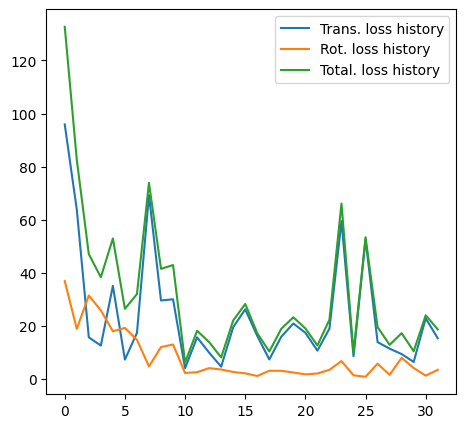

loss_1:  tensor(6.4707, device='cuda:0', grad_fn=<MulBackward0>)
loss_2:  tensor(3.4507, device='cuda:0', grad_fn=<MulBackward0>)
loss_1:  tensor(3.6208, device='cuda:0', grad_fn=<MulBackward0>)
loss_2:  tensor(2.7420, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
epochs = 50000
b_size = 20
N_max = 50000
epoch = 0
sz = 300
linit = 1000000
t_loss, r_loss, tot_loss = [], [], []
while epoch<epochs:
    o1, o2, o3 = [], [], []
    try:
        rnds = random.sample(range(N_max),b_size)
        for ids in rnds:
            img_rd = cv2.imread(img_dir+str(ids)+'img'+'.jpg')
            pose_id = torch.load(pos_dir+str(ids)+'pose.pt')
            img_tsr_rd = F.interpolate(torch.tensor(img_rd/255.0).permute(2,0,1).unsqueeze(0), size=(sz,sz), mode='bilinear', align_corners=False)
            o1.append(img_tsr_rd.squeeze(0))
            o2.append(pose_id[0:3])
            o3.append(pose_id[3:])
        o1 = torch.stack(o1,0).float()
        o2 = torch.vstack(o2).float()
        o3 = torch.vstack(o3).float()
        d_set = (o1, o2, o3)
        o_loss = training_loop1(d_set, optimz, lsfunc, mod1)
        t_loss.append(o_loss[0]), r_loss.append(o_loss[1]), tot_loss.append(o_loss[2])
        if o_loss[-1]<linit:
            torch.save(mod1.state_dict(), './align_net.pth')
        if epoch%10==0:
            viz_history(t_loss, r_loss, tot_loss)
        epoch += 1
    except:
        pass

In [ ]:
#### Train the feedback network
mod2 = feedback_net() ##Feedback network
mod2.load_state_dict(torch.load('./INAF/releases/mod_smb_cstr_ss5.pth')) #Load pretrained weight
mod2 = mod2.to(device).train()
optimz2 = optim.Adam([{'params': mod2.parameters(), 'lr': 1e-4}])

In [ ]:
def viz_history2(tot_loss):
    clear_output(wait=True)
    plt.figure(figsize=(6, 5))
    plt.plot(tot_loss, label='Total. loss history')
    plt.legend()
    plt.show()

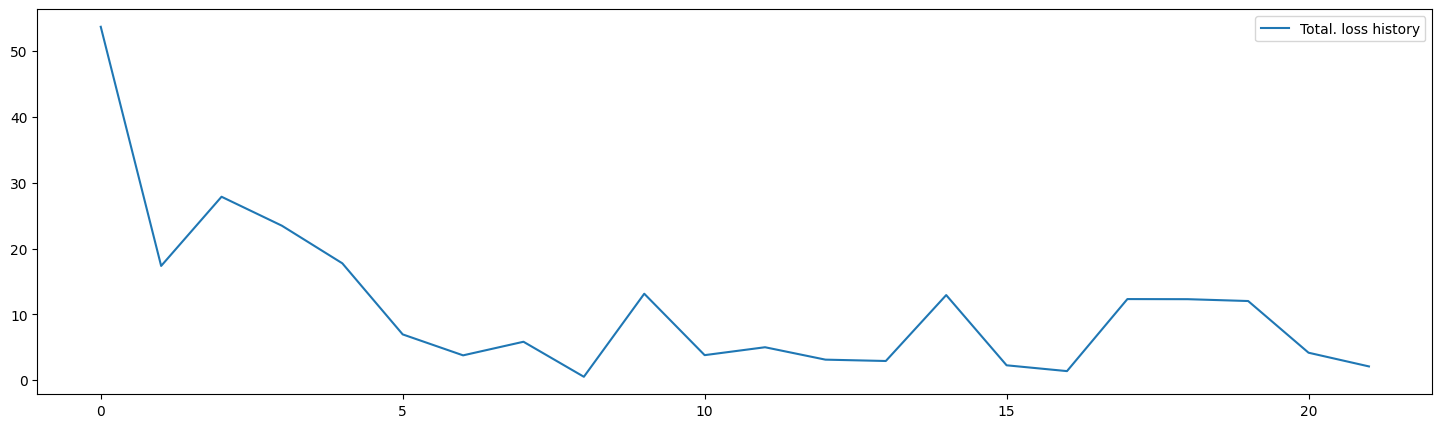

loss_3:  tensor(17.8398, device='cuda:0', grad_fn=<MulBackward0>)
loss_3:  tensor(5.1491, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
epochs = 50000
b_size = 20
N_max = 50000
epoch = 0
sz = 300
linit = 1000000
c_loss = []
while epoch<epochs:
    o4, o5 = [], []
    try:
        rnds = random.sample(range(N_max),b_size)
        for ids in rnds:
            img_rd = cv2.imread(img_dir+str(ids)+'img'+'.jpg')
            score_id = torch.load(score_dir+str(ids)+'clsr.pt')
            img_tsr_rd = F.interpolate(torch.tensor(img_rd/255.0).permute(2,0,1).unsqueeze(0), size=(sz,sz), mode='bilinear', align_corners=False)
            o4.append(img_tsr_rd.squeeze(0))
            o5.append(score_id.flatten())

        o4 = torch.stack(o4,0).float()
        o5 = torch.vstack(o5).float()

        d_set = (o4, o5)
        o_loss = training_loop2(d_set, optimz2, lsfunc, mod2)
        c_loss.append(o_loss[0])
        if o_loss[-1]<linit:
            torch.save(mod2.state_dict(), './feedback_net.pth')
        if epoch%10==0:
            viz_history2(c_loss)
        epoch += 1
    except:
        pass